In [24]:
from abc import abstractmethod

import numpy as np
import numpy.linalg as lin

import matplotlib.pyplot as plt

from math import *

In [25]:
VARIANT_NUMBER = 8
a = sin(VARIANT_NUMBER)
b = cos(VARIANT_NUMBER)
p = lambda x: 0
q = lambda x: (1 + b * x**2) / a 
f = lambda x: -1 / a

In [26]:
class AbstactSecondOrderODESolver:
    def __init__(self, n, p, q, f, left_bound, right_bound):
        self.n = n
        
        self.p = p
        self.q = q
        self.f = f
        
        self.left_bound = left_bound
        self.right_bound = right_bound
        
        self.solution_coefficients = None
        
    def _phi(self, i):
        if i == 0:
            return lambda x: 0
        else:
            return lambda x : (x ** (i - 1)) * (1 - x**2) if i >= 1 and x != 0 else 0
        
    def _phi_first_derivative(self, i):
        if i == 0:
            return lambda x: 0
        else:
            return lambda x : (i - 1) * x**(i - 2) - (i + 1) * x**i if i >= 2 and x != 0 else 0

    def _phi_second_derivative(self, i):
        if i == 0:
            return lambda x: 0
        else:
            return lambda x : (i - 1) * (i - 2) * x**(i - 3) - (i + 1) * i * x**(i - 1) if i >= 3 and x!= 0 else 0
        
    def residual(self, x_point):
        assert self.solution_coefficients is not None, 'Not solved'
        equation_left_part = np.sum(np.dot(np.vectorize(lambda i: self._phi_second_derivative(i)(x_point) \
                                                 + self.p(x_point) * self._phi_first_derivative(i)(x_point) \
                                                 + self.q(x_point) * self._phi(i)(x_point))(np.arange(1, self.n + 1)), self.solution_coefficients))
        return equation_left_part - self.f(x_point)
    
    def solution(self):
        assert self.solution_coefficients is not None, 'Not solved'        
        return lambda x: np.dot(np.array([self._phi(i)(x) for i in range(1, self.n + 1)]), self.solution_coefficients)
    
    def plot_solution(self):
        x = np.linspace(-1, 1, 10000)
        plt.plot(x, np.vectorize(self.solution())(x))
    
    @abstractmethod
    def solve(self, **kwargs):
        pass

In [27]:
class AbstractIntegralBasedSolver(AbstactSecondOrderODESolver):    
    def __init__(self, n, p, q, f, left_bound, right_bound, **kwargs):
        super().__init__(n, p, q, f, left_bound, right_bound)
        self.a = kwargs['a'] if 'a' in kwargs else None
        self.b = kwargs['b'] if 'b' in kwargs else None

    
    def _simpson_method(func, a, b, n = 100):
        h = (b - a) / n 
        x_points = a + np.arange(n + 1) * h
        vectorized_func = np.vectorize(func)
        p = vectorized_func(x_points) + 4 * vectorized_func(x_points + 1/2 * h) + vectorized_func(x_points + h) 
        return np.sum(p) * h / 6
    
    
    def _middle_point_method(func, a, b, n = 100):
        h = (b - a) / n
        x_points = a + np.arange(n + 1) * h
        p = np.vectorize(func)((x_points[1:] + x_points[:-1])/2)
        return np.sum(p) * h
    
    def _trapezial_method(func, a, b, n = 100):
        h = (b - a) / n
        x_points = a + np.arange(n + 1) * h
        y_points = np.vectorize(func)(x_points)
        p = (y_points[1:] + y_points[:-1]) / 2
        return np.sum(p) * h 
    
    
    _numerical_methods = {'simpson': _simpson_method, 'middle_point': _middle_point_method, 'trapezial': _trapezial_method}
    
    
    def _solve_numerically(self, method):
        if method not in self._numerical_methods:
            raise ValueError('There is no method {}'.format(method))

        if self._left_integrating_function is None or self._right_integrating_function is None:
            raise ValueError('There is no integrating function')
            
        integrating_method = self._numerical_methods[method]

        B = np.zeros(self.n)
        A = np.zeros((self.n, self.n))

        for i in range(1, self.n + 1):
            B[i - 1] = integrating_method(lambda x: self._right_integrating_function(i, x), self.left_bound, self.right_bound, 333) 
            for j in range(1, self.n + 1):
                A[i - 1, j - 1] = integrating_method(lambda x: self._left_integrating_function(i, j, x), self.left_bound, self.right_bound, 333)

        self.solution_coefficients = np.linalg.solve(A, B)

        
    @abstractmethod
    def solve(self, method):
        pass

## Collocation method

In [28]:
class CollocationSolver(AbstactSecondOrderODESolver):            
    def solve(self):
        collocation_points = np.linspace(self.left_bound,  self.right_bound, self.n).reshape(-1, 1)
        collocation_points[self.n // 2] += 0.1 if self.n % 2 == 1 else 0
        
        b = np.vectorize(lambda x: self.f(x) - self._phi_second_derivative(0)(x) 
                         - self.p(x) * self._phi_first_derivative(0)(x) 
                         - self.q(x) * self._phi(0)(x))(collocation_points)
        A = np.vectorize(lambda x, i: self._phi_second_derivative(i)(x) + 
                         self.p(x) * self._phi_first_derivative(i)(x) + 
                         self.q(x) * self._phi(i)(x))(collocation_points, np.arange(1, self.n + 1))
        self.solution_coefficients = np.linalg.solve(A, b)

In [29]:
solver = CollocationSolver(20, p, q, f, -1, 1)

In [30]:
solver.solve()

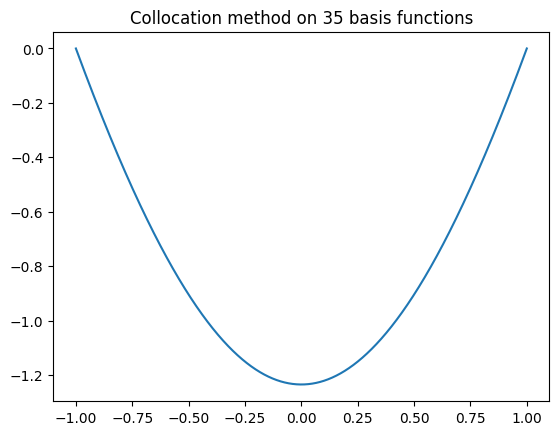

In [31]:
plt.title('Collocation method on 35 basis functions')
solver.plot_solution()
plt.savefig('collocation35.jpg')

## Galerkin method

In [32]:
class GalerkinSolver(AbstractIntegralBasedSolver):
    def solve(self, method = 'simpson'):
        if method == 'direct':
            if self.a is None or self.b:
                raise ValueError('There is no a and b parameters')
            
            left_undefinite_integral_residual_times_phi_i = lambda i, j, x: self.a * j * (j - 1) / (j + i - 1) * x**(j + i - 1) + (1 - 2 * self.a * (j**2 + j + 1)) * x**(i + j + 1) / (i + j + 1) + \
            (self.b - 2 + self.a * (j**2 + 3 * j + 2)) / (i + j + 3) * x**(i + j + 3) + (1 - 2 * self.b) / (i + j + 5) * x**(j + i + 5) + self.b / (i + j + 7) * x**(i + j + 7)
            left_definite_integral_residual_rimes_phi_i = lambda i, j: left_undefinite_integral_residual_times_phi_i(i, j, self.right_border) - left_undefinite_integral_residual_times_phi_i(i, j, self.left_border)

            right_undefinite_integral_residual_times_phi_i = lambda i, x: x**(i + 3) / (i + 3) - x**(i + 1) / (i + 1)
            right_definite_integral_residual_times_phi_i = lambda i: right_undefinite_integral_residual_times_phi_i(i, self.right_border) - right_undefinite_integral_residual_times_phi_i(i, self.left_border)
        
            B = np.vectorize(right_definite_integral_residual_times_phi_i)(np.arange(1, self.n + 1))
            A = np.vectorize(left_definite_integral_residual_rimes_phi_i)(np.arange(1, self.n + 1).reshape(-1, 1), np.arange(1, self.n + 1))
            
            self.solution_coefficients = np.linalg.solve(A, B)
        
        else:            
            self._left_integrating_function = lambda i, j, x: (self._phi_second_derivative(j)(x) 
                                                               + self.p(x) * self._phi_first_derivative(j)(x) 
                                                               + self.q(x) * self._phi(j)(x)) * self._phi(i)(x)
            self._right_integrating_function = lambda i, x: self.f(x) * self._phi(i)(x)
            
            self._solve_numerically(method)

In [33]:
solver = GalerkinSolver(100, p, q, f, -1, 1)
solver.solve('simpson')

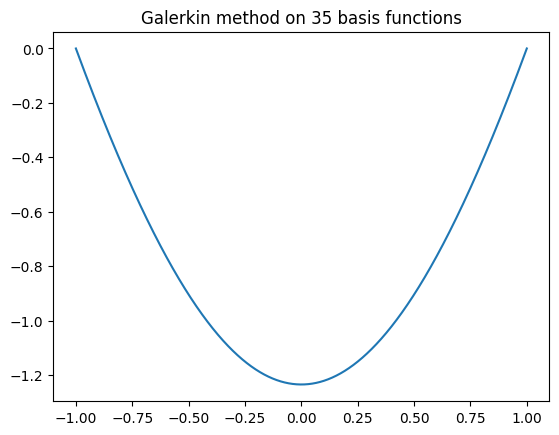

In [34]:
plt.title('Galerkin method on 35 basis functions')
solver.plot_solution()
plt.savefig('galerkin35.jpg')

In [35]:
np.sum(np.vectorize(solver.residual)(np.linspace(-1, 1, 300)))

2.443163400478454e-07

## Integral least squares method 

In [36]:
class IntegralLSMSolver(AbstractIntegralBasedSolver):
    def solve(self, method = 'simpson'):
        self._left_integrating_function = lambda i, j, x: (self._phi_second_derivative(j)(x) \
                                                    + self.p(x) * self._phi_first_derivative(j)(x) \
                                                    + self.q(x) * self._phi(j)(x) - self.f(x)) * (self._phi_second_derivative(i)(x) \
                                                    + self.p(x) * self._phi_first_derivative(i)(x) \
                                                    + self.q(x) * self._phi(i)(x))

        self._right_integrating_function = lambda i, x: self.f(x) * (self._phi_second_derivative(i)(x) 
                                                         + self.p(x) * self._phi_first_derivative(i)(x) 
                                                         + self.q(x) * self._phi(i)(x))
        self._solve_numerically(method)

In [37]:
solver = IntegralLSMSolver(20, p, q, f, -1, 1)
solver.solve()

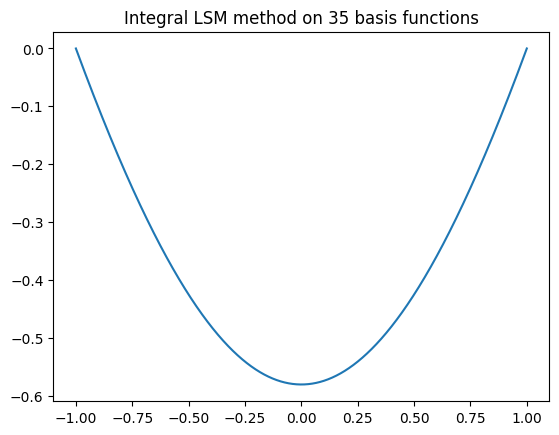

In [38]:
plt.title('Integral LSM method on 35 basis functions')
solver.plot_solution()
plt.savefig('integrallsm_35.jpg')

In [39]:
np.sum(np.vectorize(solver.residual)(np.linspace(-1, 1, 50)))

26.767813412407254

## Discrete least squares method

In [40]:
class DiscreteLSMSolver(AbstactSecondOrderODESolver):
    def __init__(self, n, p, q, f, left_bound, right_bound, n_points):
        super().__init__(n, p, q, f, left_bound, right_bound)
        self.n_points = n_points
    
    
    def solve(self):
        if self.n_points <= self.n:
            raise ValueError("Number of points must be grater than number of basis polynoms")
            
        x_points = np.linspace(self.left_bound, self.right_bound, self.n_points).reshape(-1, 1)
    
              
        left_function = lambda i, j, x: (self._phi_second_derivative(j)(x) \
                                        + self.p(x) * self._phi_first_derivative(j)(x) \
                                        + self.q(x) * self._phi(j)(x) - self.f(x)) * (self._phi_second_derivative(i)(x) \
                                        + self.p(x) * self._phi_first_derivative(i)(x) \
                                        + self.q(x) * self._phi(i)(x))

        right_function = lambda i, x: self.f(x) * (self._phi_second_derivative(i)(x) \
                                        + self.p(x) * self._phi_first_derivative(i)(x) 
                                        + self.q(x) * self._phi(i)(x))
  
        A = np.zeros((self.n, self.n))
        b = np.zeros(self.n)
        
        for i in range(1, self.n + 1):
            b[i - 1] = np.sum(np.vectorize(lambda x: right_function(i, x))(x_points))
            for j in range(1, self.n + 1):
                A[i - 1, j - 1] = np.sum(np.vectorize(lambda x: left_function(i, j, x))(x_points))
                
        self.solution_coefficients = np.linalg.solve(A, b)

In [41]:
n = 5
m = n + 1
solver = DiscreteLSMSolver(n, p, q, f, -1, 1, m)
solver.solve()

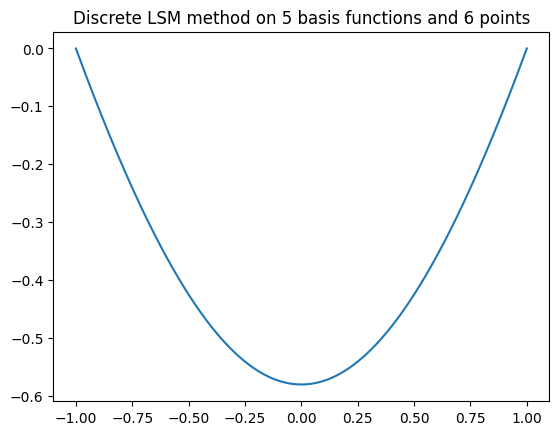

In [42]:
plt.title(f'Discrete LSM method on {n} basis functions and {m} points')
solver.plot_solution()
plt.savefig(f'discretelsm_{n}_{m}.jpg')

## Testing

In [43]:
def test_residual(n_points_from, n_points_to, n_points_step, test_points_amount, solvers):
    n_points_vector = np.arange(n_points_from, n_points_to, n_points_step)
    solver_generators = dict()
    
    if 'collocation' in solvers:
        solver_generators['collacation'] = np.vectorize(lambda n_points: CollocationSolver(n_points, p, q, f, -1, 1))
    if 'galerkin' in solvers:
        solver_generators['galerkin'] = np.vectorize(lambda n_points: GalerkinSolver(n_points, p, q, f, -1, 1))
    if 'integral_lsm' in solvers:
        solver_generators['integral_lsm'] = np.vectorize(lambda n_points: IntegralLSMSolver(n_points, p, q, f, -1, 1))
    if 'discrete_lsm' in solvers:
        solver_generators['disrete_lsm'] = np.vectorize(lambda n_points: DiscreteLSMSolver(n_points, p, q, f, -1, 1, n_points * 2))
    
    test_points = np.linspace(-1, 1, test_points_amount)
    legend = []
    
    for key, solver_generator in solver_generators.items():
        current_type_solvers = solver_generator(n_points_vector)
        
        x = list()
        y = list()
        
        for index, solver in enumerate(current_type_solvers):
            solver.solve()
            residual = np.sum(np.vectorize(lambda x_point: solver.residual(x_point))(test_points)) / test_points_amount
            x.append(n_points_vector[index])
            y.append(residual)        
        plt.plot(x, y, label=key)
        legend.append(key)
   
    plt.title('Dependency of basis functions amount \n and average residual over {} points'.format(test_points_amount))
    plt.xlabel('Basis functions amount')
    plt.ylabel('Average residual over {} points'.format(test_points_amount))
    plt.legend(legend)

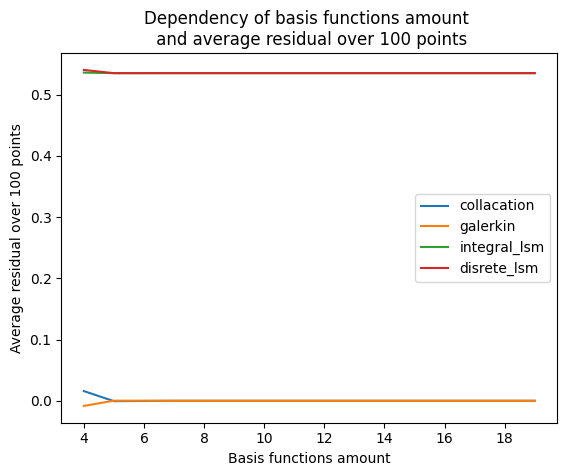

In [44]:
test_residual(4, 20, 1, 100, ['collocation', 'galerkin', 'integral_lsm', 'discrete_lsm'])
plt.savefig('residuals_average.jpg')

In [45]:
def plot_solutions(n_points_from, n_points_to, n_points_step, solver, points_multiplier = 2):
    n_points_vector = np.arange(n_points_from, n_points_to, n_points_step)
    solver_generator = None
    
    if 'collocation' == solver:
        solver_generator = np.vectorize(lambda n_points: CollocationSolver(n_points, p, q, f, -1, 1))
    if 'galerkin' == solver:
        solver_generator = np.vectorize(lambda n_points: GalerkinSolver(n_points, p, q, f, -1, 1))
    if 'integral_lsm' == solver:
        solver_generator = np.vectorize(lambda n_points: IntegralLSMSolver(n_points, p, q, f, -1, 1))
    if 'discrete_lsm' == solver:
        solver_generator = np.vectorize(lambda n_points: DiscreteLSMSolver(n_points, p, q, f, -1, 1, int(n_points * points_multiplier)))
        
    solvers = solver_generator(n_points_vector)    
        
    for solver in solvers:
        solver.solve()
        solver.plot_solution()

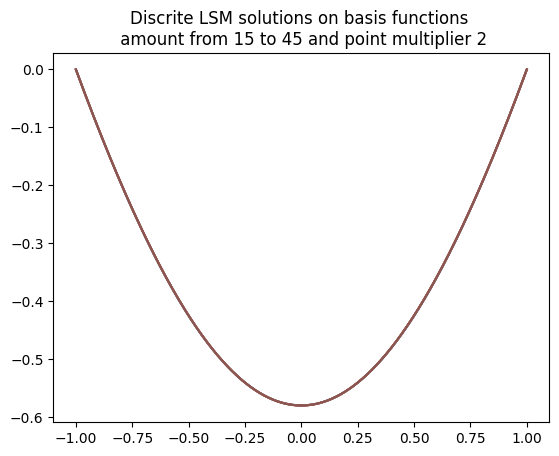

In [46]:
mul = 2
plt.title(f'Discrite LSM solutions on basis functions \n amount from 15 to 45 and point multiplier {mul}')
plot_solutions(4, 10, 1, 'integral_lsm')
plt.savefig(f'discretelsm_15_to_45_({mul}).jpg')